In [21]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import os

In [22]:
# Load the dataset
mat = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines.mat')
mat_gt = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines_gt.mat')

data = mat['indian_pines']
labels = mat_gt['indian_pines_gt']

# Reshape the data to (num_samples, num_features)
n, m, num_samples = data.shape
data_reshaped = np.reshape(data, (n*m, num_samples))
labels_reshaped = np.reshape(labels, (n*m,))

In [23]:
def save_fig(img, name, dir = '../output/pca/', keep_axis = True):
    _ , ax = plt.subplots(figsize=(4,4), dpi=100)
    ax.imshow(img, interpolation='nearest')
    if not keep_axis:
        ax.set_axis_off()
    # ax.xaxis.set_major_locator(plt.NullLocator())
    # ax.yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(os.path.join(dir,name), bbox_inches='tight', pad_inches=0, transparent=True, edgecolor='none', facecolor='none')

In [24]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

data_scaled = StandardScaler().fit_transform(data_reshaped)


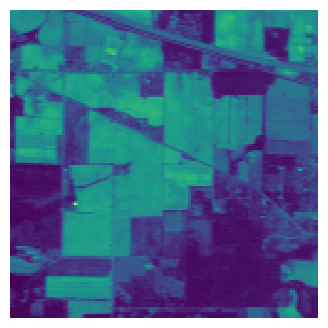

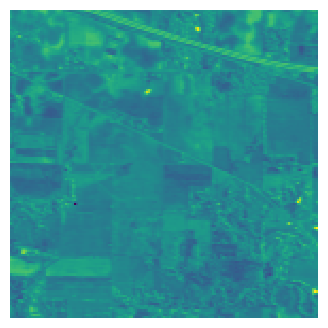

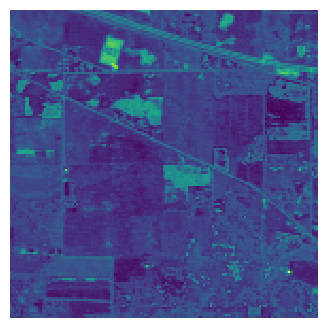

In [27]:
def pca(X, num_components):
    # Center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # Calculate the covariance matrix
    cov_matrix = np.cov(X_centered.T)
    
    # Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort the eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:,sorted_indices]
    
    # Select the top k eigenvectors
    principal_components = sorted_eigenvectors[:,:num_components]
    
    # Project the data onto the new subspace
    data_pca = np.dot(X_centered, principal_components)
    
    return data_pca

# Perform PCA to reduce the dimensionality of the data
num_components = 16
data_pca = pca(data_scaled, num_components)

save_fig(data_pca[:,0].reshape(n,m), 'pca_1.png' ,dir='../output/pca/', keep_axis=False)
save_fig(data_pca[:,1].reshape(n,m), 'pca_2.png', dir='../output/pca/', keep_axis=False)
save_fig(data_pca[:,2].reshape(n,m), 'pca_3.png', dir='../output/pca/', keep_axis=False)


In [18]:

from keras.models import Sequential
from keras.layers import Dense, Conv1D

# Define the neural network architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=data_pca.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(17, activation='softmax'))

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to one-hot encoding
num_labels = len(np.unique(labels_reshaped))
labels_onehot = np.eye(num_labels)[labels_reshaped.reshape(-1)]

# print(labels_onehot)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_pca, labels_onehot, test_size=0.3, random_state=42)

# Train the neural network on the training set
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the neural network on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)

model.save('../models/lda_model.h5')

Epoch 1/50
368/368 [==============================] - 1s 2ms/step - loss: 1.4221 - accuracy: 0.5697 - val_loss: 1.1764 - val_accuracy: 0.5819
Epoch 2/50
368/368 [==============================] - 1s 1ms/step - loss: 1.0622 - accuracy: 0.6228 - val_loss: 1.0528 - val_accuracy: 0.6179
Epoch 3/50
368/368 [==============================] - 1s 1ms/step - loss: 0.9935 - accuracy: 0.6401 - val_loss: 1.0041 - val_accuracy: 0.6294
Epoch 4/50
368/368 [==============================] - 1s 1ms/step - loss: 0.9535 - accuracy: 0.6510 - val_loss: 0.9704 - val_accuracy: 0.6342
Epoch 5/50
368/368 [==============================] - 1s 1ms/step - loss: 0.9145 - accuracy: 0.6631 - val_loss: 0.9483 - val_accuracy: 0.6369
Epoch 6/50
368/368 [==============================] - 1s 1ms/step - loss: 0.8911 - accuracy: 0.6692 - val_loss: 0.9104 - val_accuracy: 0.6562
Epoch 7/50
368/368 [==============================] - 1s 1ms/step - loss: 0.8715 - accuracy: 0.6775 - val_loss: 0.9232 - val_accuracy: 0.6586
Epoch 

658/658 [==============================] - 1s 993us/step
Clustered labels accuracy: 0.7245184304399525
MSE: 26.81074910820452


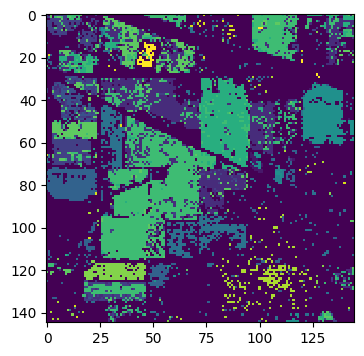

In [19]:
# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_pca)
# smoothed_preds = np.apply_along_axis(lambda x: np.convolve(x, [1/3, 1/3, 1/3], mode='same'), axis=1, arr=cluster_labels_onehot)
cluster_labels = np.argmax(cluster_labels_onehot, axis=1)

cluster_labels_reshaped = np.reshape(cluster_labels, (n, m))
accuracy = np.mean(cluster_labels_reshaped == labels)
print("Clustered labels accuracy:", accuracy)

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
save_fig(cluster_labels_reshaped, 'pca_nn_without_gauss.png')

658/658 [==============================] - 1s 925us/step


100%|██████████| 299/299 [00:00<00:00, 537.09it/s]


Best sigma=0.8 with accuracy=0.7608
MSE: 28.929036860879904


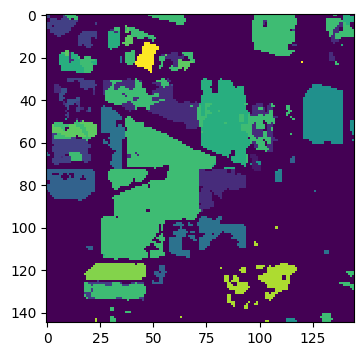

In [12]:
import cv2
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

sigmas = np.arange(0.01, 3.00, 0.01)  # different values of sigma to try
best_accuracy = 0
best_sigma = 0

# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_pca)
preds = np.reshape(cluster_labels_onehot, (n, m, 17))

for sigma in tqdm(sigmas):
    smoothed_preds = cv2.GaussianBlur(preds, (0, 0), sigma)

    cluster_labels_reshaped = np.argmax(smoothed_preds, axis=2)
    accuracy = np.mean(cluster_labels_reshaped == labels)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sigma = sigma
        best_image = cluster_labels_reshaped

print(f"Best sigma={best_sigma:.1f} with accuracy={best_accuracy:.4f}")

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
save_fig(best_image, 'pca_nn_with_gauss.png')